# **SAINT: Improved Neural Networks for Tabular Data via Row Attention and Contrastive Pre-Training**

### **This kernel explains SAINT model architecture**
### **Contrastive Pre-Taining is not included**

## **Reference**
* [Paper](https://arxiv.org/abs/2106.01342)
* [Github](https://github.com/ogunlao/saint)

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gc
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold

import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, Embedding, Input, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu, softmax
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-dec-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-dec-2021/test.csv')

# **Memory Reduce Func**

* **If you don't use some memory reducing strategy, you can face some OOM**

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

# **Feature Engineering**

* **Check Missing Values**
* **Check Target Column**

* **Soil_Type7 & Soil_Type15 → useless**

In [ ]:
train = train.drop(columns = ['Id', 'Soil_Type7', 'Soil_Type15'])
test = test.drop(columns = ['Id', 'Soil_Type7', 'Soil_Type15'])

## **Check Missing Values**

* **Looking good!**

In [ ]:
train['Cover_Type'].value_counts()

In [ ]:
train = train.drop(index = train[train['Cover_Type'] == 5].index).reset_index(drop = True)
train['Cover_Type'].value_counts()

## **Aspect**

* **Aspect means angle. Good for rescaling**
* **Hillshade needs to rescale to 0 ~ 255**

From [gulshanmishra Kernel](https://www.kaggle.com/gulshanmishra/tps-dec-21-tensorflow-nn-feature-engineering)

Thank you for sharing nice notebook :)

In [ ]:
train["Aspect"][train["Aspect"] < 0] += 360
train["Aspect"][train["Aspect"] > 359] -= 360

test["Aspect"][test["Aspect"] < 0] += 360
test["Aspect"][test["Aspect"] > 359] -= 360

In [ ]:
train.loc[train["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
test.loc[test["Hillshade_9am"] < 0, "Hillshade_9am"] = 0

train.loc[train["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
test.loc[test["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0

train.loc[train["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
test.loc[test["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0

train.loc[train["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
test.loc[test["Hillshade_9am"] > 255, "Hillshade_9am"] = 255

train.loc[train["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
test.loc[test["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255

train.loc[train["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
test.loc[test["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255

## **Interaction Features**

* **Sum of Hydrology**
* **Subtraction of Hydrology**

In [ ]:
train['Sum_Hydrology'] = np.abs(train['Horizontal_Distance_To_Hydrology']) + np.abs(train['Vertical_Distance_To_Hydrology'])
train['Sub_Hydrology'] = np.abs(train['Horizontal_Distance_To_Hydrology']) - np.abs(train['Vertical_Distance_To_Hydrology'])

test['Sum_Hydrology'] = np.abs(test['Horizontal_Distance_To_Hydrology']) + np.abs(test['Vertical_Distance_To_Hydrology'])
test['Sub_Hydrology'] = np.abs(test['Horizontal_Distance_To_Hydrology']) - np.abs(test['Vertical_Distance_To_Hydrology'])

# **Target Encoding**

### **Need to use inverse_transform at the end for submission**

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(train['Cover_Type'].values)

In [ ]:
from sklearn.preprocessing import OneHotEncoder


oe = OneHotEncoder()
target = oe.fit_transform(y.reshape(-1, 1))
target = target.toarray()

train = train.drop(columns = 'Cover_Type')
gc.collect()

# **Data Preparing**

* **Add a column named 'cls' to our dataset. The 'cls' column should be the first column as mentioned in paper**
* **Apply z-transform to numerical columns**
* **Label encode categorical columns**
* **It is required that categorical columns are separated from numerical columns.**

## **Label Encoding Categorical Columns**
### **There are 2 categorical columns!**
* **Soil_Type**
* **Wilderness_Area**

In [ ]:
train['Soil_Type'] = 0
train['Wilderness_Area'] = 0

test['Soil_Type'] = 0
test['Wilderness_Area'] = 0

soil_columns = train.columns[-42:-4]
area_columns = train.columns[-46:-42]

In [ ]:
train['Soil_Type'] = np.argmax(train[soil_columns].values, axis = -1)
train['Wilderness_Area'] = np.argmax(train[area_columns].values, axis = -1)
test['Soil_Type'] = np.argmax(test[soil_columns].values, axis = -1)
test['Wilderness_Area'] = np.argmax(test[area_columns].values, axis = -1)

In [ ]:
train.drop(columns = soil_columns, inplace = True)
train.drop(columns = area_columns, inplace = True)

test.drop(columns = soil_columns, inplace = True)
test.drop(columns = area_columns, inplace = True)

display(train, test)

## **Include 'CLS' columns and move it to first column**
### **Column order : Categorical → Numerical**

In [ ]:
columns = ['cls', 'Soil_Type', 'Wilderness_Area', 'Elevation', 'Aspect',
           'Slope', 'Horizontal_Distance_To_Hydrology',
           'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
           'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
           'Horizontal_Distance_To_Fire_Points', 'Sum_Hydrology', 'Sub_Hydrology']

In [ ]:
train['cls'] = 0
test['cls'] = 0

train = train[columns]
test = test[columns]

display(train, test)

## **Scaling**

* **Standard Scaling Numerical Columns**

In [ ]:
num_columns = train.columns[3:]

# Scaling
sc = StandardScaler()

train[num_columns] = sc.fit_transform(train[num_columns].values)
test[num_columns] = sc.transform(test[num_columns].values)

display(train, test)

In [ ]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

train = train.values
test = test.values

gc.collect()

## **Done!**

# **Modeling**

## **Multi-Head Attention Layer**

In [ ]:
class MHA(Layer):
    '''
    Multi-Head Attention Layer
    '''
    
    def __init__(self, num_head, dropout = 0):
        super(MHA, self).__init__()
        
        # Constants
        self.num_head = num_head
        self.dropout_rate = dropout
        
    def build(self, input_shape):
        query_shape = input_shape
        d_model = query_shape[-1]
        units = d_model // self.num_head
        
        # Loop for Generate each Attention
        self.layer_q = []
        for _ in range(self.num_head):
            layer = Dense(units, activation = None, use_bias = False)
            layer.build(query_shape)
            self.layer_q.append(layer)
            
        self.layer_k = []
        for _ in range(self.num_head):
            layer = Dense(units, activation = None, use_bias = False)
            layer.build(query_shape)
            self.layer_k.append(layer)
            
        self.layer_v = []
        for _ in range(self.num_head):
            layer = Dense(units, activation = None, use_bias = False)
            layer.build(query_shape)
            self.layer_v.append(layer)
            
        self.out = Dense(d_model, activation = None, use_bias = False)
        self.out.build(query_shape)
        self.dropout = Dropout(self.dropout_rate)
        self.dropout.build(query_shape)
        
    def call(self, x):
        d_model = x.shape[-1]
        scale = d_model ** -0.5
        
        attention_values = []
        for i in range(self.num_head):
            attention_score = softmax(tf.matmul(self.layer_q[i](x), self.layer_k[i](x), transpose_b=True) * scale)
            attention_final = tf.matmul(attention_score, self.layer_v[i](x))
            attention_values.append(attention_final)
            
        attention_concat = tf.concat(attention_values, axis = -1)
        out = self.out(self.dropout(attention_concat))
        
        return out

## **Intersample Multi-Head Attention Layer**

## **The structure of the layer is as shown in the picture below by original paper.**

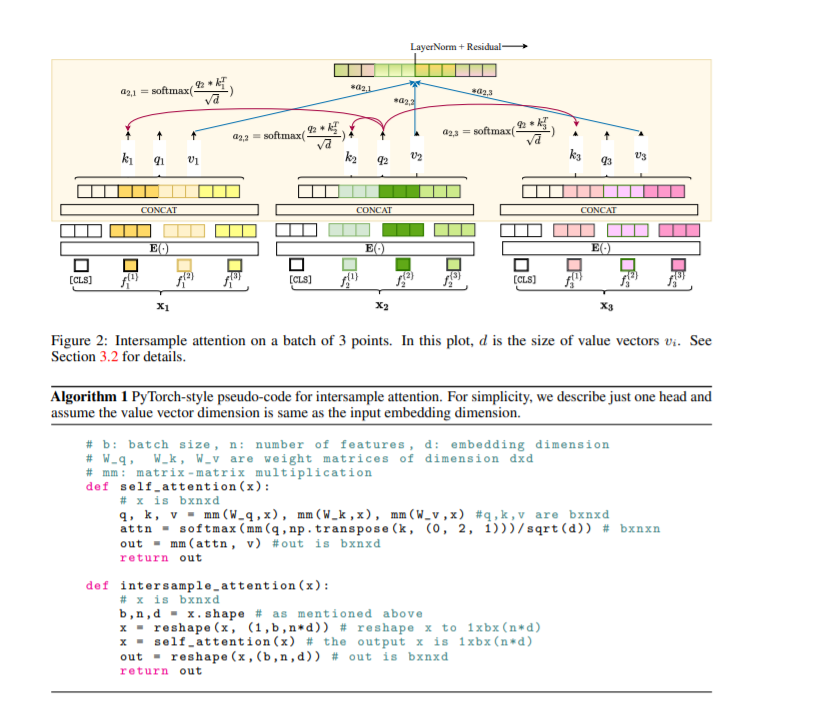

In [ ]:
class IMHA(Layer):
    '''
    Intersample Multi Head Attention
    Attend on row(samples) not column(features)
    '''
    
    def __init__(self, num_head, dropout = 0):
        super(IMHA, self).__init__()
        
        # Constants
        self.num_head = num_head
        self.dropout_rate = dropout
        
    def build(self, input_shape):
        b, n, d = input_shape
        query_shape = input_shape
        units = (d * n) // self.num_head
        # Loop for Generate each Attention
        self.layer_q = []
        for _ in range(self.num_head):
            layer = Dense(units, activation = None, use_bias = False)
            layer.build([1, b, int(n * d)])
            self.layer_q.append(layer)
            
        self.layer_k = []
        for _ in range(self.num_head):
            layer = Dense(units, activation = None, use_bias = False)
            layer.build([1, b, int(n * d)])
            self.layer_k.append(layer)
            
        self.layer_v = []
        for _ in range(self.num_head):
            layer = Dense(units, activation = None, use_bias = False)
            layer.build([1, b, int(n * d)])
            self.layer_v.append(layer)
            
        self.out = Dense(d, activation = None, use_bias = False)
        self.out.build(query_shape)
        self.dropout = Dropout(self.dropout_rate)
        self.dropout.build(query_shape)
        
    def call(self, x):
        b, n, d = x.shape
        scale = d ** -0.5
        x = tf.reshape(x, (1, b, int(n * d)))
        attention_values = []
        
        for i in range(self.num_head):
            attention_score = softmax(tf.matmul(self.layer_q[i](x), self.layer_k[i](x), transpose_b=True) * scale)
            attention_final = tf.matmul(attention_score, self.layer_v[i](x))
            attention_final = tf.reshape(attention_final, (b, n, int(d / self.num_head)))
            attention_values.append(attention_final)
            
        attention_concat = tf.concat(attention_values, axis = -1)
        out = self.out(self.dropout(attention_concat))
        
        return out

## **FeedForward Layer**

In [ ]:
class FeedForwardNetwork(Layer):
    def __init__(self, dim, dropout = 0.0):
        super(FeedForwardNetwork, self).__init__()
        self.dense = Dense(dim, activation = 'gelu')
        self.dropout = Dropout(dropout)
        
    def call(self, x):
        return self.dropout(self.dense(x))

## **Custom Embedding**

* **Because there are negative values in numerical, we need to seperate numerical columns and categorical columns and apply Dense for numerical embedding, Embedding for categorical columns**

In [ ]:
class CustomEmbedding(Layer):
    def __init__(self, num_categorical, dim):
        super(CustomEmbedding, self).__init__()
        self.num_categorical = num_categorical
        self.dim = dim
        
    def build(self, input_shape):
        b, n = input_shape
        self.embedding_categorical = Embedding(self.dim * 2, self.dim)
        self.embedding_categorical.build([b, self.num_categorical])
        
        self.embedding_numerical = Dense(self.dim, activation = 'relu')
        self.embedding_numerical.build([b, int(n - self.num_categorical), 1])
        
    def call(self, x):
        b, n = x.shape
        categorical_x = x[:, :self.num_categorical]
        numerical_x = x[:, self.num_categorical:]
        numerical_x = tf.reshape(numerical_x, (b, int(n - self.num_categorical), 1))
        
        embedded_cat = self.embedding_categorical(categorical_x)
        embedded_num = self.embedding_numerical(numerical_x)
    
        embedded_x = tf.concat([embedded_cat, embedded_num], axis = 1)
        
        return embedded_x

# **SAINT Model**

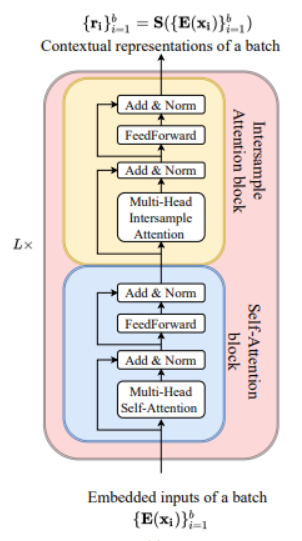

In [ ]:
class SAINT(Layer):
    def __init__(self, repeat, num_categorical, EMB_DIM, MHA_HEADS, IMHA_HEADS):
        super(SAINT, self).__init__()
        self.repeat = repeat
        self.layer_mha = []
        self.layer_imha = []
        self.layer_ffn = []
        self.layer_layernorm = []
        self.embedding = CustomEmbedding(num_categorical, EMB_DIM)
        
        for _ in range(repeat):
            mha = MHA(MHA_HEADS)
            imha = IMHA(IMHA_HEADS)
            ffn_1 = FeedForwardNetwork(EMB_DIM)
            ffn_2 = FeedForwardNetwork(EMB_DIM)
            layernorm_1 = LayerNormalization()
            layernorm_2 = LayerNormalization()
            layernorm_3 = LayerNormalization()
            layernorm_4 = LayerNormalization()
            
            self.layer_mha.append(mha)
            self.layer_imha.append(imha)
            self.layer_ffn.append(ffn_1)
            self.layer_ffn.append(ffn_2)
            self.layer_layernorm.append(layernorm_1)
            self.layer_layernorm.append(layernorm_2)
            self.layer_layernorm.append(layernorm_3)
            self.layer_layernorm.append(layernorm_4)
            
    def call(self, x):
        x = self.embedding(x)
        
        # Depth of SAINT Layer
        for i in range(self.repeat):
            # Multi-Head part
            x = self.layer_layernorm[i](self.layer_mha[i](x)) + x
            x = self.layer_layernorm[i+1](self.layer_ffn[i](x)) + x
            
            # Intersample Multi-Head part
            x = self.layer_layernorm[i+2](self.layer_imha[i](x)) + x
            x = self.layer_layernorm[i+3](self.layer_ffn[i+1](x)) + x
       
        # only using cls token for final output
        out = x[:, 0] # CLS Token
        
        return out

# **Training**

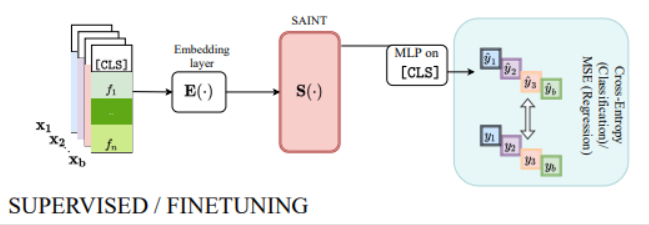

In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## **DataLoader**

* **Because of the remaining last batch, it makes the shape error! So we need to drop it**

In [ ]:
def DataLoader(x, y, batch_size, shuffle = False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.batch(batch_size, drop_remainder = True)
    if shuffle:
        ds = ds.shuffle(len(x))
        
    return ds

## **You can modify some args for better result**

* Decrease Batch Size
* Increase Epochs
* Change optimizer and using LR schedular (Paper used AdamW)

In [ ]:
EPOCH = 5
BATCH_SIZE = 4096
NUM_FOLDS = 5

kf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state=2021)
test_preds = []

with tpu_strategy.scope():
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, y)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)

        checkpoint_filepath = f"folds{fold}.hdf5"
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = target[train_idx], target[test_idx]
        
        train_ds = DataLoader(X_train, y_train, BATCH_SIZE, shuffle = True)
        valid_ds = DataLoader(X_valid, y_valid, BATCH_SIZE, shuffle = False)
        
        model = Sequential([
            Input(shape = (15,), batch_size = BATCH_SIZE),
            SAINT(3, 3, 64, 8, 8),
            Dense(6, activation = 'softmax')
        ])

        model.compile(optimizer = "adam",
                      loss = "categorical_crossentropy",
                      metrics = ['accuracy'])

        lr = ReduceLROnPlateau(monitor = "val_loss",
                               factor = 0.5,
                               patience = 2,
                               verbose = 1)

        es = EarlyStopping(monitor = "val_loss",
                           patience = 3,
                           verbose = 1,
                           restore_best_weights = True)

        model.fit(train_ds,
                  validation_data = valid_ds,
                  epochs = EPOCH,
                  batch_size = BATCH_SIZE,
                  
                  callbacks = [lr, es])

        test_preds.append(model.predict(test))

        del X_train, X_valid, y_train, y_valid, model
        gc.collect()

In [ ]:
sub = pd.read_csv('../input/tabular-playground-series-dec-2021/sample_submission.csv')
sub['Cover_Type'] = le.inverse_transform(np.argmax(np.array(test_preds).sum(axis = 0), axis = 1))
sub

In [ ]:
sub.to_csv('sub.csv', index = 0)

## **Thanks a lot for your interest**